Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [3]:
FN = 'vocabulary-embedding'

In [4]:
seed=42

In [5]:
vocab_size = 40000

In [6]:
embedding_dim = 100

In [8]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [7]:
import cPickle as pickle
FN0 = 'tokens' # this is the name of the data file which I assume you already have
with open('data/%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [9]:
if lower:
    heads = [h.lower() for h in heads]

In [10]:
if lower:
    desc = [h.lower() for h in desc]

In [11]:
i=0
heads[i]

'Remainders : Super wi-fi edition'

In [12]:
desc[i]

"! Google 's free San Fran wi-fi will track your location . Oh , do n't worry , they have some clause about evil , right ? ! Silicon Valley , meanwhile , plans its own wi-fi coverage . It 'll be like San Fran 's , only with fewer homeless trustafarians using it . ! Soon you 'll have wi-fi on the BART . Caveat : After a few days on those seats , your laptop will smell like urine . ! Boy in the Bubble : The sad story"

In [13]:
keywords[i]

['Google',
 'Gawker',
 'Remainders',
 'WiFi',
 'Valleywag',
 'Nyt',
 'Vcs',
 'San Francisco']

In [14]:
len(heads),len(set(heads))

(684114, 672187)

In [15]:
len(desc),len(set(desc))

(684114, 683908)

# build vocabulary

In [16]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [17]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [18]:
print vocab[:50]
print '...',len(vocab)

[',', '.', 'the', 'a', 'to', 'of', "'s", 'and', 'in', 'The', 'is', 'for', 'that', ':', 'on', "''", '``', 'you', 'it', 'with', '?', 'at', "n't", 'this', "'", '(', 'was', ')', 'has', 'be', 'are', 'from', 'as', '--', 'A', 'an', 'I', 'his', '!', 'have', 'by', 'but', 'It', 'In', 'we', 'your', 'To', 'about', 'he', 'You']
... 523732


/Users/udi/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


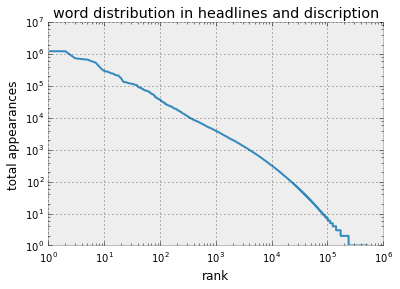

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [21]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [22]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [23]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [24]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

In [25]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [26]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

In [27]:
glove_embedding_weights.std()

0.040815727600190289

In [28]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [30]:

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

random-embedding/glove scale 0.0706949139514 std 0.0408138249575
number of tokens, in small vocab, found in glove and copied to embedding 39332 0.9833


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [31]:
glove_thr = 0.5

In [34]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [47]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

# of glove substitutes found 122377


manually check that the worst substitutions we are going to do are good enough

In [48]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

0.500009203566 CQ => Deletes
0.500009203566 cq => Deletes
0.500005559501 cheapskate => dude
0.500005559501 Cheapskate => dude
0.500004635765 Stoney => Ridgeway
0.500004635765 stoney => Ridgeway
0.500003799 Maia => Joanna
0.500003553879 Jammy => fruity
0.500003553879 jammy => fruity
0.500003378034 ataxia => OCD


build a lookup table of index of outside words to index of inside words

In [49]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)